# GHZ state in Rydberg atoms (CUDA)

In [1]:
using Sisyphus
using QuantumOptics
using LinearAlgebra
using Flux, DiffEqFlux
using Plots
using ProgressMeter
using Random
ProgressMeter.ijulia_behavior(:clear)

false

In [2]:
bs = SpinBasis(1//2)
sx = sigmax(bs)
ni = 0.5*(identityoperator(bs) + sigmaz(bs));

In [3]:
V = 2π*24.0
δe = -2π*4.5

-28.274333882308138

In [4]:
n_atoms = 16
bsys = tensor([bs for i in 1:n_atoms]...)

H0 = V*sum([embed(bsys, [i, j], [ni, ni])/abs(i-j)^6  for i in 1:n_atoms for j in i+1:n_atoms])
H0 -= δe*sum([embed(bsys, [i], [ni]) for i in [1, n_atoms]])
if n_atoms>8
    H0 -= -2π*1.5*sum([embed(bsys, [i], [ni]) for i in [1, n_atoms]])
    H0 -= -2π*1.5*sum([embed(bsys, [i], [ni]) for i in [4, n_atoms-3]])
end;

H1 = 0.5*sum([embed(bsys, [i], [sx]) for i in 1:n_atoms])
H2 = -sum([embed(bsys, [i], [ni]) for i in 1:n_atoms]);

In [5]:
function GHZ_state(n_atoms)
    state = tensor([spindown(bs)⊗spinup(bs) for i in 1:Int(n_atoms/2)]...) +
            tensor([spinup(bs)⊗spindown(bs) for i in 1:Int(n_atoms/2)]...)
    state/sqrt(2.0)
end 

ground_state(n_atoms) = tensor([spindown(bs) for i in 1:n_atoms]...)
trans = StateTransform(ground_state(n_atoms)=>GHZ_state(n_atoms));

In [6]:
T = 1.1f0
Ω₀(t) = 2.f0π * min(5, 25 * t / T, 25 * (T - t) / T)

Ω₀ (generic function with 1 method)

In [7]:
Ω(p, t) = piecewise_const_interp(p[begin:length(p)-2], t; t0=0.f0, t1=T)
Δ(p, t) = p[end-1]*t + p[end]

n_params = 20
ts = 0:T/(n_params-2):T
θ = (vcat([Ω₀((ts[i+1] + ts[i])/2) for i=1:n_params-2], 2.f0π*[30/T, -15]));

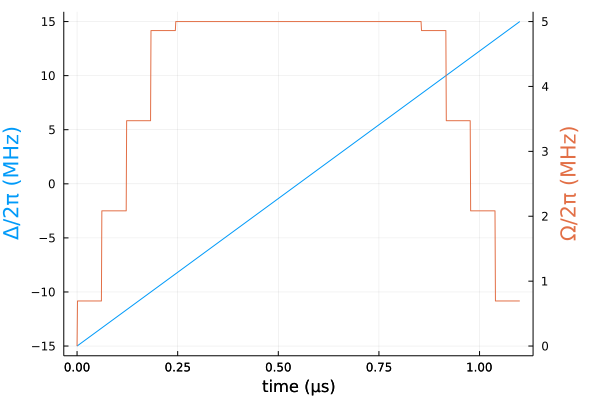

In [8]:
ts = 0:T/1000:T

blue = theme_palette(:auto).colors.colors[1]
red = theme_palette(:auto).colors.colors[2]
plot(ts, [Δ(θ, t)/2π for t in ts], ylabel="Δ/2π (MHz)", color=blue, yguidefont = font(blue), legend=false)
plot!(Plots.twinx(), ts, [Ω(θ, t)/2π for t in ts], ylabel="Ω/2π (MHz)", color=red, yguidefont = font(red), legend=false)
plot!(xlabel="time (μs)", right_margin = 15Plots.mm)

In [9]:
cost = CostFunction((x, y) -> 1.0f0 - abs2(sum(conj(x).*y)))

CostFunction(var"#29#30"(), nothing)

In [10]:
H = Hamiltonian(H0, [H1, H2], (p, t) -> [Ω(p, t), Δ(p, t)]);

In [11]:
prob = cu(convert(Float32, QOCProblem(H, trans, (0.0, Float64(T)), cost)));

In [12]:
@time sol = solve(prob, Vector{Float32}(θ), ADAM(0.5f0); maxiter=60, abstol=1e-5, reltol=1e-5)

Progress: 100%|█████████████████████████████████████████| Time: 1:04:55
  distance:     0.14893913
  constraints:  0.0


3943.376298 seconds (2.47 G allocations: 82.475 GiB, 1.34% gc time, 2.37% compilation time)


Solution{Float32}(Float32[8.132387, 6.254851, 16.87701, 27.292034, 38.762474, 35.514427, 32.840717, 35.747673, 26.317242, 31.769138, 26.352428, 28.457672, 31.089022, 35.126503, 37.837715, 33.345055, 20.531998, 11.850042, 160.635, -85.93381], Float32[0.38781625, 0.3351711, 0.29689872, 0.27643716, 0.26351196, 0.25058532, 0.24053651, 0.23353988, 0.22954822, 0.22459096  …  0.15819484, 0.1571632, 0.15608937, 0.15436864, 0.15362132, 0.15257686, 0.1519208, 0.14995301, 0.14944446, 0.14893913], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Vector{Float32}[])

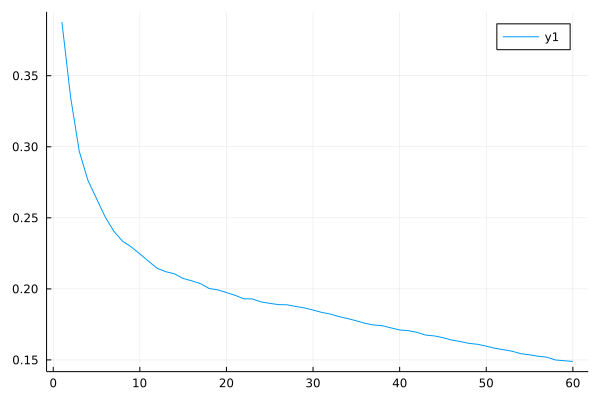

In [13]:
plot(sol.distance_trace)

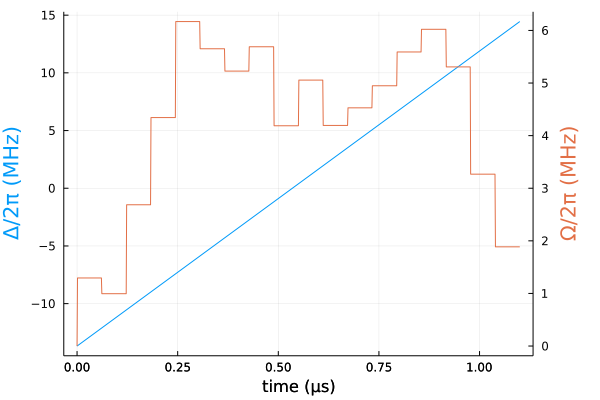

In [14]:
blue = theme_palette(:auto).colors.colors[1]
red = theme_palette(:auto).colors.colors[2]
plot(ts, [Δ(sol.params, t)/2π for t in ts], ylabel="Δ/2π (MHz)",
     color=blue, yguidefont = font(blue), legend=false)
plot!(Plots.twinx(), ts, [Ω(sol.params, t)/2π for t in ts],
     ylabel="Ω/2π (MHz)", color=red, yguidefont = font(red), legend=false)
plot!(xlabel="time (μs)", right_margin = 15Plots.mm)